# PyPSA-Eur style power system plot

## Authored by F.Hofmann

The notebook reproduces the plot like a beautiful scheme of the
European Transmission System published in https://arxiv.org/abs/1806.01613.

In [40]:
#"""
#Created on Mon Sep 19 15:51:31 2022
#
#@author: fabian
#"""

In [41]:
import pypsa
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import plotly.express as px
import hvplot.pandas
import matplotlib.colors as mcolors

Two files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may by found in "resources/shapes/country_shapes.geojson")

In [42]:
scenario_name = "nz_2030_exp"  # scenario name, default value is "" for tutorial or default configuration
                    # value shall be non null if a scenario name is specified under the "run" tag in the config file

scenario_subpath = scenario_name + "/" if scenario_name else ""

export_level = 40

n=pypsa.Network(f"../../results/" + scenario_name + f"/postnetworks/elec_s_10_ec_lc3.0_Co2L_3H_2030_0.071_AB_{export_level}export.nc")
regions_onshore = gpd.read_file("../../results/shapes/country_shapes.geojson")

INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2030_0.071_AB_40export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [43]:
OUTPUT = f"../../results/figures/" + scenario_name + f"/allcarrier_{export_level}export.pdf"
OUTPUT_png = f"../../results/figures/" + scenario_name + f"/allcarrier_{export_level}export.png"

Define plot parameters:

In [44]:
bus_scale = 5e3 
line_scale = 8e2
capacity_scale = 10

In [45]:
extent = [165.0, 180.0, -48.0, -33.0] # for country NZ [165.0, 180.0, -50.0, -25.0] 
parameter = "p_nom_opt"

In [46]:
# Select only certain carriers, in this case "gas" is excluded. Note; the carrier color must be present in n.carriers.color
carrier_sel = ['geothermal', 'onwind', 'solar', 'ror', 'CCGT', 'OCGT', 'coal',
       'offwind-ac', 'offwind-dc', 'oil']

In [47]:
gen = n.generators[n.generators.carrier.isin(carrier_sel)].groupby(["bus", "carrier"])[parameter].sum()
sto = n.storage_units.groupby(["bus", "carrier"])[parameter].sum()
buses = pd.concat([gen, sto])
buses.name = "p_nom"

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor 

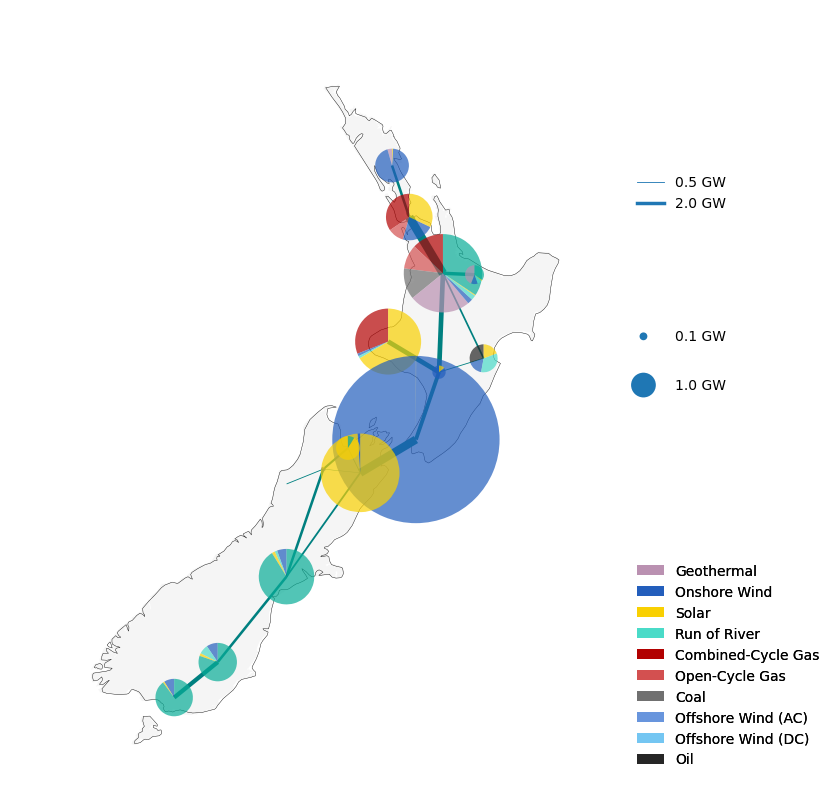

In [48]:
# fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(), "frameon": False})

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses[n.buses.carrier == "AC"].x.mean())})

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )

regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)

ax.set_extent(extent)
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 2.5, **legend_kwargs}
bus_sizes = [100, 1e3]  # in MW
line_sizes = [500, 2000]  # in MW
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.loc[carrier_sel].color,
    n.carriers.loc[carrier_sel].nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)


fig.tight_layout()
fig.savefig(OUTPUT, bbox_inches="tight", dpi=300)
fig.savefig(OUTPUT_png, bbox_inches="tight", dpi=300)